# Quickstart

In [1]:
import os

# uncomment to disable NVIDIA GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# or pick the device (cpu, gpu, and tpu)
# os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1'
os.environ['JAX_ENABLE_X64']= 'True'

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA A100-PCIE-40GB


In [2]:
import BFast #for computing bispectra with jax on gpu, see github.com/tsfloss/BFast
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
jax.numpy.set_printoptions(precision=8)

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, linear_transfer,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter
)
from pmwd.vis_util import simshow
from pmwd.spec_util import powspec

## Simulate Forward

`Configuration` stores static configuration and parameters for which we do not need derivatives.

In [83]:
if jax.lib.xla_bridge.get_backend().platform == 'gpu':
    ptcl_spacing = 3.90625  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (256,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

conf = Configuration(ptcl_spacing, ptcl_grid_shape,mesh_shape=2,a_start=1/(1+9),a_nbody_maxstep=0.09)  # 2x mesh shape

In [84]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=3.90625,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(512, 512, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.1,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.09,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
Simulating 16777216 pa

`Cosmology` stores interesting parameters, whose derivatives we need.

In [86]:
cosmo_LC_p = Cosmology(conf, A_s_1e9=2.13, n_s=0.9624, Omega_m=0.3175, Omega_b=0.049, h=0.6711,f_nl_loc=100.)
cosmo_LC_m = Cosmology(conf, A_s_1e9=2.13, n_s=0.9624, Omega_m=0.3175, Omega_b=0.049, h=0.6711,f_nl_loc=-100.)

# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo_LC_p,cosmo_LC_m)

Cosmology(A_s_1e9=Array(2.13, dtype=float64),
          n_s=Array(0.962, dtype=float64),
          Omega_m=Array(0.318, dtype=float64),
          Omega_b=Array(0.049, dtype=float64),
          h=Array(0.671, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          f_nl_loc=Array(100., dtype=float64),
          transfer=None,
          growth=None,
          varlin=None) Cosmology(A_s_1e9=Array(2.13, dtype=float64),
          n_s=Array(0.962, dtype=float64),
          Omega_m=Array(0.318, dtype=float64),
          Omega_b=Array(0.049, dtype=float64),
          h=Array(0.671, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          f_nl_loc=Array(-100., dtype=float64),
          transfer=None,
          growth=None,
          varlin=None)


``boltzmann`` computes the transfer and growth functions and caches them in ``Cosmology``.

The first run is slower because it includes the **JIT compilation** time. JAX uses **asynchronous dispatch** to hide Python overheads. To measure the true cost, use ``DeviceArray.block_until_ready()`` to wait for the computation to complete.

In [87]:
cosmo_LC_p = boltzmann(cosmo_LC_p, conf)
cosmo_LC_m = boltzmann(cosmo_LC_m, conf)

Generate a white noise field, and scale it with the linear power spectrum:

CPU times: user 838 ms, sys: 46.8 ms, total: 885 ms
Wall time: 605 ms


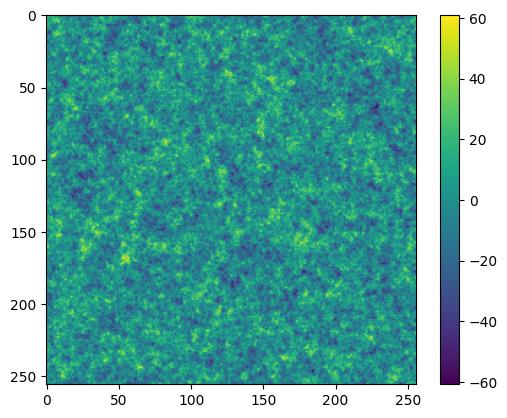

In [88]:
seed = 2
modes_white = white_noise(seed, conf)

%time modes_LC_p = linear_modes(modes_white, cosmo_LC_p, conf)

plt.imshow(jnp.fft.irfftn(modes_LC_p).mean(0))
plt.colorbar()

CPU times: user 2.03 ms, sys: 2 µs, total: 2.03 ms
Wall time: 1.61 ms


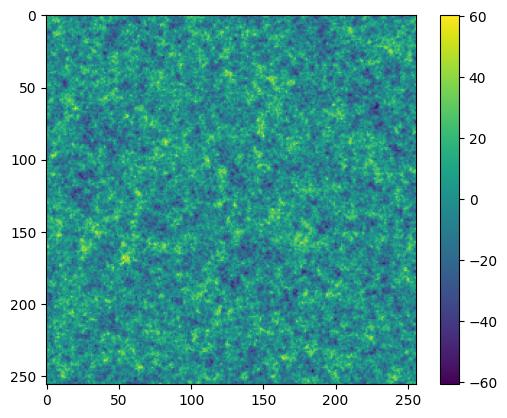

In [89]:
seed = 2
modes_white = white_noise(seed, conf)

%time modes_LC_m = linear_modes(modes_white, cosmo_LC_m, conf)

plt.imshow(jnp.fft.irfftn(modes_LC_m).mean(0))
plt.colorbar()

In [90]:
B_LC_p = BFast.Bk(jnp.fft.irfftn(modes_LC_p),1000.,3.,3.,27,triangle_type='All',verbose=True)
B_LC_m = BFast.Bk(jnp.fft.irfftn(modes_LC_m),1000.,3.,3.,27,triangle_type='All',verbose=True)

Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All)
Loading Counts from ./BFast_BkCounts_Grid256_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All)


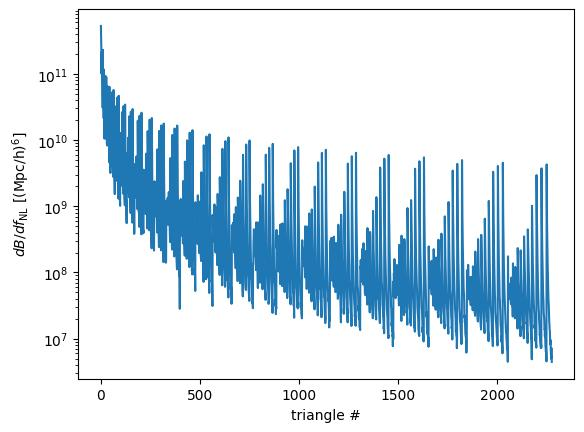

In [91]:
plt.semilogy((B_LC_p[:,-2] - B_LC_m[:,-2])/200.)
plt.ylabel("$dB/df_{\\rm NL}$ [(Mpc/h)$^6$]")
plt.xlabel("triangle #")
plt.show()

Solve LPT at some early time:

In [92]:
ptcl_LC_p, obsvbl_LC_p = lpt(modes_LC_p, cosmo_LC_p, conf)
ptcl_LC_p.disp.std(), ptcl_LC_p.vel.std()

(Array(0.749, dtype=float32), Array(0.134, dtype=float32))

In [93]:
ptcl_LC_m, obsvbl_LC_m = lpt(modes_LC_m, cosmo_LC_m, conf)
ptcl_LC_m.disp.std(), ptcl_LC_m.vel.std()

(Array(0.749, dtype=float32), Array(0.134, dtype=float32))

Finally, N-body time integration from the LPT initial conditions:

In [94]:
ptcl_LC_p, obsvbl_LC_p = nbody(ptcl_LC_p, obsvbl_LC_p, cosmo_LC_p, conf)
ptcl_LC_p.disp.std(), ptcl_LC_p.vel.std()

(Array(6.007, dtype=float32), Array(3.373, dtype=float32))

In [95]:
ptcl_LC_m, obsvbl_LC_m = nbody(ptcl_LC_m, obsvbl_LC_m, cosmo_LC_m, conf)
ptcl_LC_m.disp.std(), ptcl_LC_m.vel.std()

(Array(6.001, dtype=float32), Array(3.357, dtype=float32))

Scatter the particles to mesh to get the density field, and plot a slab's 2D projection:

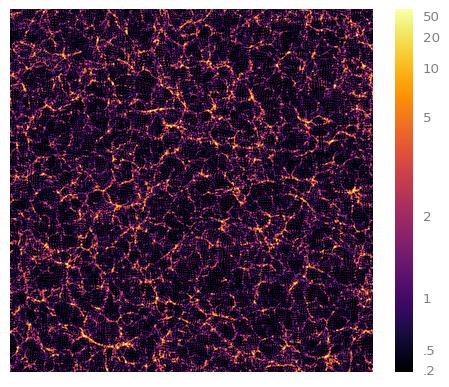

In [96]:
dens_LC_p = scatter(ptcl_LC_p, conf,)
simshow(dens_LC_p[:8].mean(axis=0), norm='CosmicWebNorm');

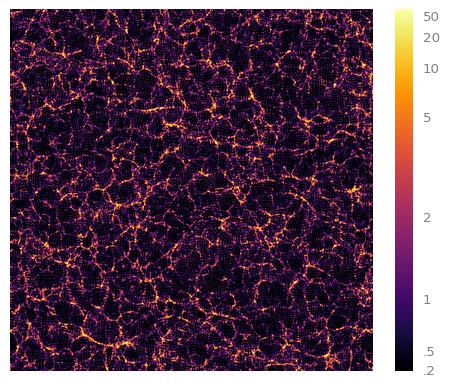

In [97]:
dens_LC_m = scatter(ptcl_LC_m, conf,)
simshow(dens_LC_m[:8].mean(axis=0), norm='CosmicWebNorm');

CPU times: user 402 µs, sys: 798 µs, total: 1.2 ms
Wall time: 919 µs
CPU times: user 807 µs, sys: 0 ns, total: 807 µs
Wall time: 595 µs


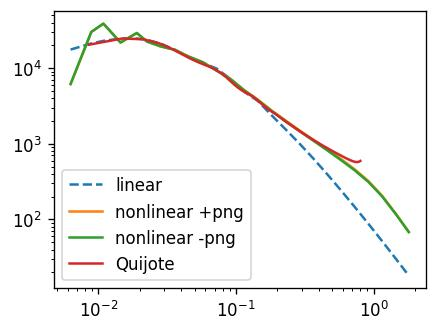

In [98]:
kQ, PQ = np.load(f'/scratch/p301831/Quijote_Measurements_npy/Pk_fiducial_z0.npy').mean(0)[:,:2].T
%time k, P_LC_p, _, _ = powspec(dens_LC_p, conf.cell_size,deconv=2.)
%time k, P_LC_m, _, _ = powspec(dens_LC_m, conf.cell_size,deconv=2.)
Plin = linear_power(k, conf.a_stop, cosmo_LC_p, conf)
plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(k, Plin, ls='--', label='linear')
plt.loglog(k, P_LC_p, ls='-', label='nonlinear +png')
plt.loglog(k, P_LC_m, ls='-', label='nonlinear -png')
plt.loglog(kQ,PQ,label='Quijote')
plt.legend();

In [99]:
B_LC_p = BFast.Bk(dens_LC_p,1000.,3,3,27,MAS='CIC',fast=False,verbose=True)
B_LC_m = BFast.Bk(dens_LC_m,1000.,3,3,27,MAS='CIC',fast=False,verbose=True)

Loading Counts from ./BFast_BkCounts_Grid512_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All)


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

Loading Counts from ./BFast_BkCounts_Grid512_BoxSize1000.00_BinSize3.00kF_FirstCenter3.00kF_NumBins27_TriangleTypeAll_OpenTrianglesTrue_Precisionfloat32.npy
Considering 2276 Triangle Configurations (All)


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2276 [00:00<?, ?it/s]

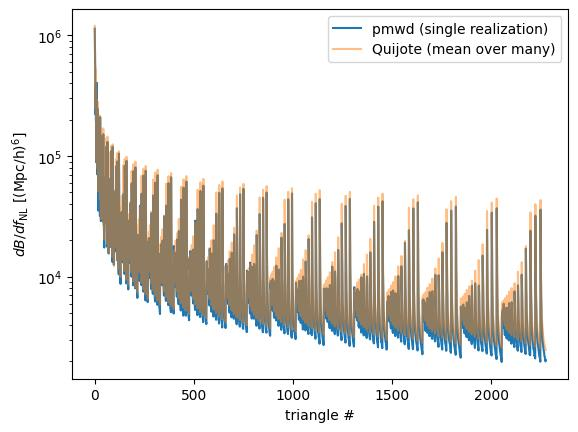

In [101]:
plt.semilogy((B_LC_p[:,-2] - B_LC_m[:,-2])/200.,label='pmwd (single realization)')
plt.semilogy((np.load("/scratch/p301831/Quijote_Measurements_npy/Bk_LC_p_z0.npy")[:,:,-2].mean(0) -  np.load("/scratch/p301831/Quijote_Measurements_npy/Bk_LC_m_z0.npy")[:,:,-2].mean(0))/200.,label='Quijote (mean over many)',alpha=.5)
plt.legend()
plt.ylabel("$dB/df_{\\rm NL}$ [(Mpc/h)$^6$]")
plt.xlabel("triangle #")
plt.show()